In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz, plot_tree
import matplotlib.pyplot as plt

In [6]:
original = pd.read_csv("../../data/processed/BankChurners_cleaned.csv")
campaign_df = pd.read_csv("../../data/processed/Campaign.csv")
segment_result = pd.read_csv("../../data/processed/segmentation_result_static.csv")

# Extracting useful columns to avoid repetition
bank_df = pd.read_csv("../../data/processed/banking_behaviour_preference.csv")
features_from_bank = ['CLIENTNUM','Credit Score',
       'Outstanding Loans', 'Balance','PhoneService','InternetService','TechSupport','PaperlessBilling','PaymentMethod']
bank_df = bank_df.loc[:,features_from_bank]

## 2. What are the key factors influencing customer engagement with our marketing campaigns?
### Analyze historical campaign data to identify main drivers of engagement.

In [9]:
# merging final_df and original
# common columnns:
original = original.merge(bank_df, on = 'CLIENTNUM', how = 'inner')
original = original.merge(campaign_df, on = 'CLIENTNUM', how = 'inner')
original = original.merge(segment_result, on = 'CLIENTNUM', how = 'inner')

In [11]:
outcome_counts = original['Outcome'].value_counts(normalize = True) * 100

success_percentage = outcome_counts.get(1, 0)
failure_percentage = outcome_counts.get(0, 0)

# Display the percentages
print(f"Success Rate: {success_percentage:.2f}%")
print(f"Failure Rate: {failure_percentage:.2f}%")

Success Rate: 12.78%
Failure Rate: 87.22%


In [13]:
ori = original.copy()
cols_to_std = ['Duration_of_Contact', 'Num_of_Contacts_Made', 'Outcome']
ori[cols_to_std] = (ori[cols_to_std] - ori[cols_to_std].mean()) / ori[cols_to_std].std()
ori[['Duration_of_Contact', 'Num_of_Contacts_Made', 'Outcome']].corr()

,Duration_of_Contact,Num_of_Contacts_Made,Outcome
Duration_of_Contact,1.000000,0.142742,0.038547
Num_of_Contacts_Made,0.142742,1.000000,0.056343
Outcome,0.038547,0.056343,1.000000


The correlation matrix does not show high correlation between Outcome and any other variable. The highest positive correlation is between Outcome and Number of Contacts Made.

All the correlations are positive which means an increase in the duration of the contact or number of contacts made could result in an increase in outcome.

The reasons why the correlations are so low is because the number of successful campaigns is low.

In the next part, Random Forest Classifier will be used to find the most important features.

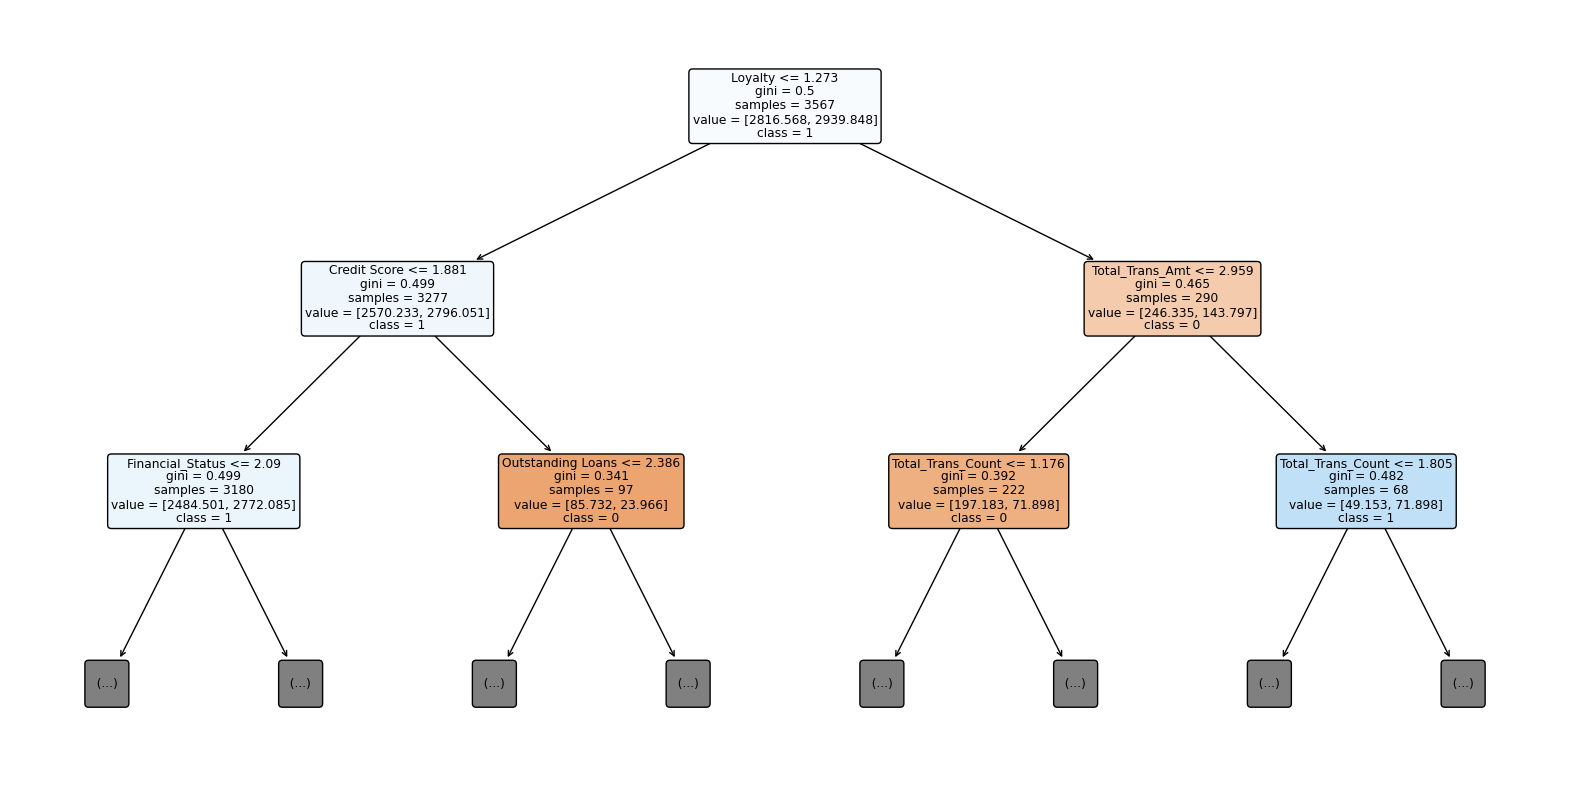

In [58]:
X = ori[['Last_Contacted', 'Num_of_Contacts_Made', 'Months_Inactive_12_mon',
         'Total_Trans_Count', 'Total_Trans_Amt', 'Savings', 'Credit Score', 
         'Outstanding Loans', 'Balance', 'Loyalty', 'Financial_Status', 'Segment', 'Digital_Capability'] + 
        [col for col in ori.columns if 'Education_Level_' in col or 
                                       'Income_Category_' in col or 
                                       'Card_Category_' in col]]

y = ori['Outcome']
y = (y >= 1).astype(int)

# splitting the data into training and test
## training data size: 80%; test data size: 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fitting the model
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 1, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

tree = rf_model.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=list(X.columns), class_names=['0', '1'], filled=True, rounded=True, max_depth=2)
plt.show()

In [60]:
# Importance
importances = rf_model.feature_importances_
impt = pd.DataFrame(importances, index = X.columns, columns = ["Importance"]).sort_values("Importance", ascending = False)
impt

,Importance
Outstanding Loans,0.131499
Balance,0.128353
Credit Score,0.127494
Total_Trans_Amt,0.125768
Savings,0.112469
Total_Trans_Count,0.107664
Num_of_Contacts_Made,0.059909
Financial_Status,0.057968
Loyalty,0.043275
Last_Contacted,0.039844


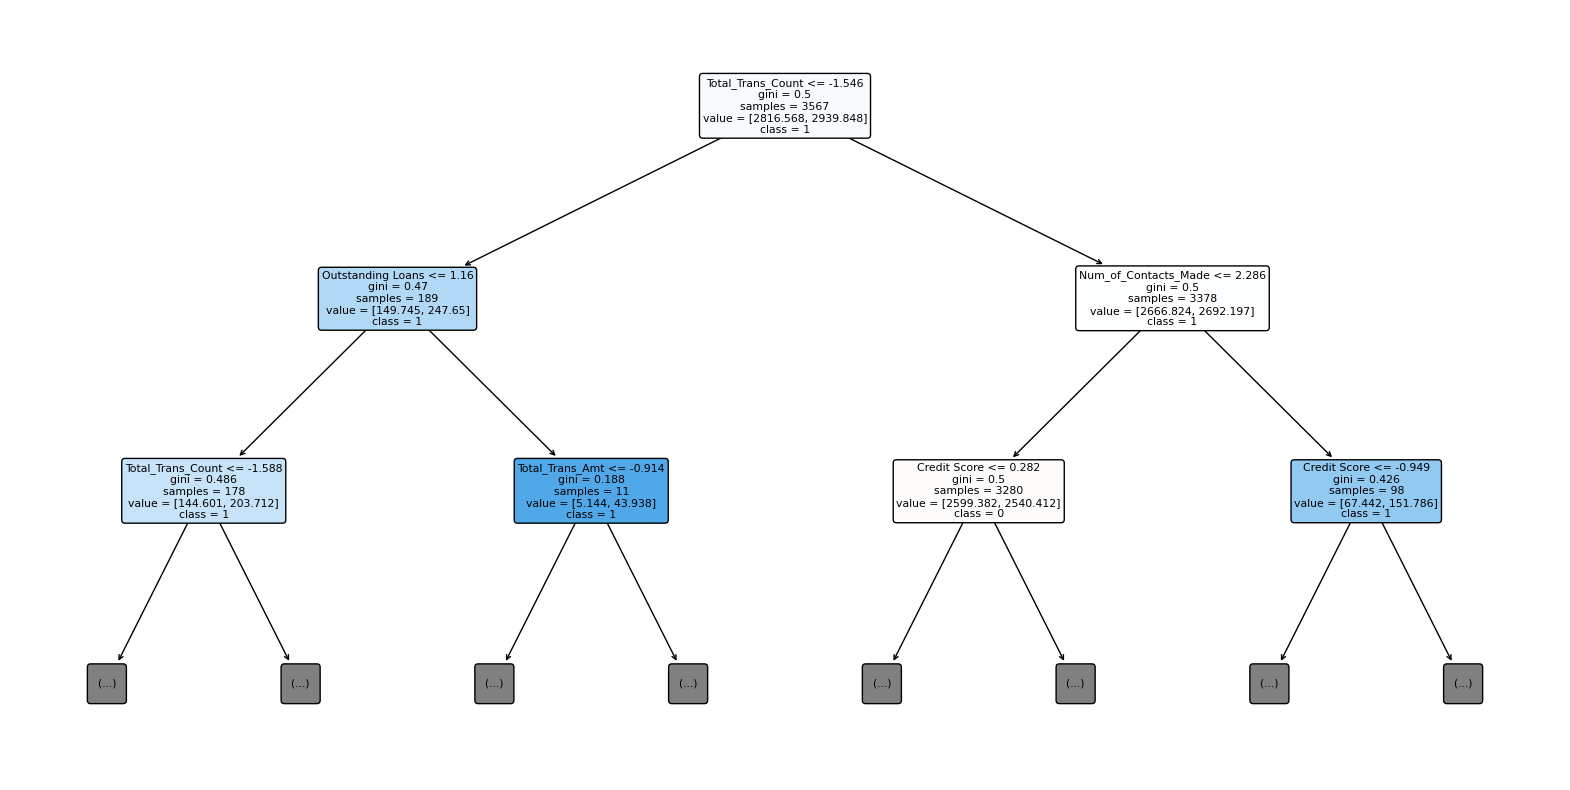

In [62]:
# removing the features that are not as important
X = ori[['Num_of_Contacts_Made', 
         'Total_Trans_Count', 'Total_Trans_Amt', 'Savings', 'Credit Score', 
         'Outstanding Loans', 'Balance', 'Financial_Status']]

y = ori['Outcome']
y = (y >= 1).astype(int)

# splitting the data into training and test
## training data size: 80%; test data size: 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fitting the model
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 1, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

tree = rf_model.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=list(X.columns), class_names=['0', '1'], filled=True, rounded=True, max_depth=2)
plt.show()

In [63]:
# Importance
importances = rf_model.feature_importances_
impt = pd.DataFrame(importances, index = X.columns, columns = ["Importance"]).sort_values("Importance", ascending = False)
impt

,Importance
Outstanding Loans,0.154360
Credit Score,0.150849
Balance,0.149748
Total_Trans_Amt,0.148661
Savings,0.128924
Total_Trans_Count,0.123551
Financial_Status,0.073574
Num_of_Contacts_Made,0.070333


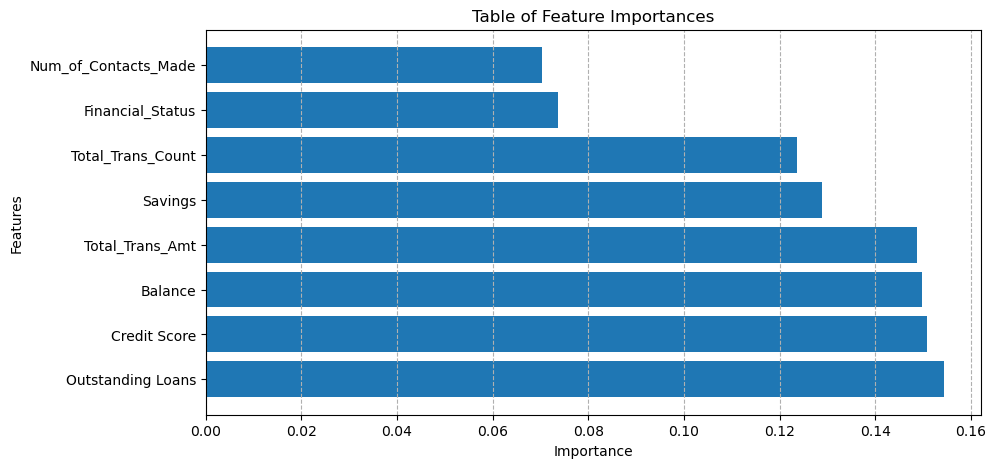

In [66]:
# Plotting the feature importances
plt.figure(figsize = (10, 5))
plt.title("Table of Feature Importances")
plt.barh(impt.index, impt["Importance"], align = "center")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.grid(axis = 'x', linestyle = '--', alpha = 1)
plt.show()

- `Outstanding Loans` (0.154360) is the most important features in this list.
- `Credit Score` (0.150849), `Balance` (0.149748), and `Total_Trans_Amt` (0.148661) follow, indicating moderate importance.
- The other features are less important features but might still play a role.

### Propose metrics for tracking campaign effectiveness over time

##### Key Factors Influencing Customer Engagement
1) Customer Segmentation:
    1. **Low Financial status, Low Loyalty** = 1
  
    2. **Moderate or low Financial status, Moderate or low Loyalty** = 2

    3. **Low or Moderate Financial status, High Loyalty** = 3

    4. **High Financial status, Low or Moderate Loyalty** = 4
   
    5. **High Financial status, High Loyalty** = 5

2) Personalization:
    - Personalization is crucial across all segments. The more tailored a campaign is to a customer’s habits, needs, and preferences, the higher the likelihood of engagement. For instance, using customer data to send offers relevant to their transaction behavior, product usage, or financial status can greatly increase engagement.

3) Communication Channel:
    - Digital capability levels directly influence the preferred channels for communication. Highly digitally engaged customers are more responsive to email, social media, or app notifications, while others may prefer direct mail or phone calls. 


##### Proposed Metrics for Tracking Campaign Effectiveness
1) Engagement Rate:
    - Tracks the overall interaction with campaigns (e.g., email opens, clicks). This is a key indicator of initial interest across all customer segments.
2) Conversion Rate:
    - Measures the percentage of customers who complete the desired action (e.g., purchase, sign-up), giving direct insight into campaign success.
3) Customer Lifetime Value (CLV):
    - Helps track long-term profitability and how successful campaigns are in retaining and increasing the value of customers over time.
4) Return on Marketing Investment (ROMI):
    - Shows the financial impact of campaigns by comparing revenue generated to campaign costs, ensuring resources are allocated efficiently.

In [70]:
# 1) Engagement Rate Calculation
def calculate_engagement_rate(df):
    total_engagements = df['Digital_Capability'].sum()  
    total_campaigns = len(df)  
    return total_engagements / total_campaigns if total_campaigns > 0 else 0

# 2) Conversion Rate Calculation
def calculate_conversion_rate(df):
    total_conversions = df[df['Outcome'] == 'Converted'].shape[0] 
    total_customers = len(df)
    return total_conversions / total_customers if total_customers > 0 else 0

# 3) Customer Lifetime Value (CLV) Calculation
def calculate_clv(df):
    # Assuming CLV can be estimated based on Balance or similar financial metrics
    return df['Balance'].mean() if 'Balance' in df.columns else 0

# 4) Return on Marketing Investment (ROMI) Calculation
def calculate_romi(df):
    total_revenue = df['Total_Trans_Amt'].sum()  # Assuming revenue is represented by Total Transaction Amount
    total_cost = df['Savings'].sum() 
    return (total_revenue - total_cost) / total_cost if total_cost > 0 else 0

# Calculate the metrics
engagement_rate = calculate_engagement_rate(ori)
conversion_rate = calculate_conversion_rate(ori)
clv = calculate_clv(ori)
romi = calculate_romi(ori)

print(f"Engagement Rate: {engagement_rate:.2f}")
print(f"Conversion Rate: {conversion_rate:.2f}")
print(f"Customer Lifetime Value (CLV): {clv:.2f}")
print(f"Return on Marketing Investment (ROMI): {romi:.2f}")

Engagement Rate: 0.89
Conversion Rate: 0.00
Customer Lifetime Value (CLV): 122817.06
Return on Marketing Investment (ROMI): -0.99


In [72]:
original.to_csv('../../data/processed/Compaign_metrics.csv', index=False)